# 分类器的不确定度估计
在实际应用中，我们感兴趣的不仅是分类器会预测一个测试点属于哪个类别，还包括对这个预测的置信程度。在实践中，不同类型的错误会在现实应用中导致非常不同的结果。想象一个用于测试癌症的医疗应用。假阳性预测可能只会让患者接受额外的测试，但假阴性预测却可能导致重病没有得到治疗。  
scikit-learn中有两个函数可用于获取分类器的不确定度估计：decision_function和predict_prob。大多数分类器（但不是全部）都至少有其中一个函数，很多分类器两个都有。我们来构建一个GradientBoostingClassifier分类器（同时拥有decision_function和predict_prob两个方法）。看一下这两个函数对一个模拟的二维数据集的作用：

In [1]:
import sys
print("Python version:{}".format(sys.version))

import pandas as pd
print("pandas version:{}".format(pd.__version__))

import matplotlib
print("matplotlib version:{}".format(matplotlib.__version__))
import matplotlib.pyplot as plt

import numpy as np
print("Numpy version:{}".format(np.__version__))

import scipy as sp
print("Scipy version:{}".format(sp.__version__))

import IPython
print("IPython version:{}".format(IPython.__version__))

import sklearn
print("scikit-learn version:{}".format(sklearn.__version__))

import mglearn
import graphviz

Python version:3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
pandas version:0.23.4
matplotlib version:3.0.2
Numpy version:1.15.4
Scipy version:1.1.0
IPython version:7.2.0
scikit-learn version:0.20.1


In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X,y=make_circles(noise=0.25,factor=0.5,random_state=1)

# 为了便于说明，我们将两个类别重命名为“blue”和“red”
y_named=np.array(["blue","red"])[y]

# 我们可以对任意个数组调用train_test_split
# 所有的数组的划分方式都是一致的
X_train,X_test,y_train_named,y_test_named,y_train,y_test=train_test_split(X,y_named,y,random_state=0)

# 构建梯度提升模型
gbrt=GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train,y_train_named)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

# 决策函数
对于二分类情况，decision_function返回值的形状是（n_samples）,为每个样本都返回一个浮点数：

In [5]:
print("X_test.shape:{}".format(X_test.shape))
print("Decision function shape:{}".format(gbrt.decision_function(X_test).shape))

X_test.shape:(25, 2)
Decision function shape:(25,)


对于类别1来说，这个值表示模型对该数据点属于“正”类的置信程度。正值表示对正类的偏好，负值表示对“反类”(其他类）的偏好：

In [6]:
# 显示decision_function的前几个数
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6]))

Decision function:
[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]


我们可以通过仅查看决策函数的正负号来再现预测值：

In [7]:
print("Thresholded decision function:\n{}".format(gbrt.decision_function(X_test)>0))
print("Prediction:\n{}".format(gbrt.predict(X_test)))

Thresholded decision function:
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Prediction:
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


对于二分类问题，“反”类始终是classes_属性的第一个元素，“正”类是classes_的第二个元素。因此，如果你想要完全再现predict的输出，需要利用classes_属性：

In [8]:
# 将布尔值True/False转换成0和1
greater_zero=(gbrt.decision_function(X_test)>0).astype(int)
# 利用0和1作为classes_的索引
pred=gbrt.classes_[greater_zero]
# pred与gbrt.predict的输出完全相同
print("pred is equal to predictions:\n{}".format(np.all(pred==gbrt.predict(X_test))))

pred is equal to predictions:
True


decision_function可以在任意范围取值，这取决于数据与模型参数：

In [9]:
decision_function=gbrt.decision_function(X_test)
print("Decision function minimum:{:.2f} maximum:{:.2f}".format(np.min(decision_function),np.max(decision_function)))

Decision function minimum:-7.69 maximum:4.29


由于可以任意缩放，因此decision_function的输出往往很难解释。  
在下面的例子中，我们利用颜色编码在二维平面中画出所有点的decision_function,还有决策边界|。我们将训练点画成圆，将测试数据画成三角：

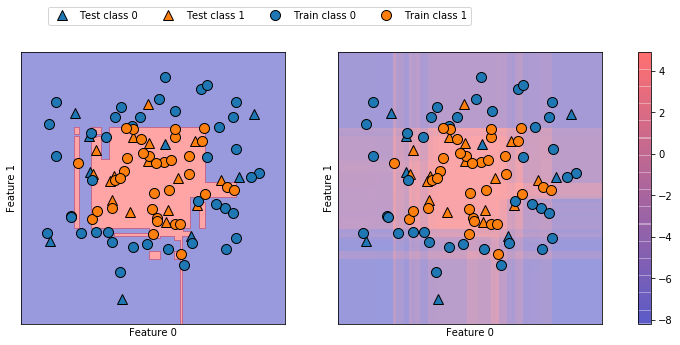

In [13]:
fig,axes=plt.subplots(1,2,figsize=(13,5))
mglearn.tools.plot_2d_separator(gbrt,X,ax=axes[0],alpha=.4,fill=True,cm=mglearn.cm2)
scores_image=mglearn.tools.plot_2d_scores(gbrt,X,ax=axes[1],alpha=.4,cm=mglearn.ReBl)

for ax in axes:
    # 画成训练点和测试点
    mglearn.discrete_scatter(X_test[:,0],X_test[:,1],y_test,markers='^',ax=ax)
    mglearn.discrete_scatter(X_train[:,0],X_train[:,1],y_train,markers='o',ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar=plt.colorbar(scores_image,ax=axes.tolist())
axes[0].legend(["Test class 0","Test class 1","Train class 0","Train class 1"],ncol=4,loc=(.1,1.1))

既给出预测结果，又给出分类器的置信程度，这样给出的信息量更大。但在上面的图像中，很难分辨出两个类别之间的边界。